##  CSE 549 Project: Uncertainty Quantification 

### Team: 

##### 111742914 (Syed Fahad Sultan)
##### 111482304 (Anjul Kumar Tyagi)
##### 111753053 (Arjun Krishna)
##### 111447392 (Rohit Rao P)

## 1. Data Preparation

Python has **Pandas** library for effectively dealing with data. We'll use Pandas for working with the given data and **Numpy** for data manipulations. For plotting graphics, we've used **Matplotlib** library. 

The first step is to create get the data from all the files in a single data frame.

Reading the data 

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import math

# Read the Bootstrap samples
data = pd.read_csv('data/poly_mo/quant_bootstraps.tsv', header=0, sep='\t')
# Read the truth values for each transcript
truth = pd.read_csv('data/poly_mo/poly_truth.tsv', header=0, index_col=0, sep='\t')
# Read the properties file for each transcript
quant = pd.read_csv('data/poly_mo/quant.sf', header=0, index_col=0, sep='\t')

Computing the **95% confidence interval** for each transcript from the given bootstrap samples. For this operation, the bootstrap samples are sorted for each transcript and then the lower and upper quartiles are computed. 

All the computer lower and upper bounds are stored in the data frame.

In [2]:
data = data.apply(lambda x: np.sort(x.values))

lower_bounds = data.apply(lambda values: values[int(math.ceil(0.025*len(values)))])
upper_bounds = data.apply(lambda values: values[int(math.floor(0.975*len(values)))])

data_mins = data.min()
data_maxs = data.max()
data_means = data.mean()
data_std = data.std()

data = data.transpose()

data['lower_bound'] = lower_bounds
data['upper_bound'] = upper_bounds
data['min'] = data_mins
data['max'] = data_maxs
data['mean'] = data_means
data['std'] = data_std

Merging with ground truth values to the original dataframe.

In [3]:
data['truth'] = truth

data = data[~data['truth'].isnull()]

Filtering out invalid transcripts i.e. for which the truth value isn't between the 95% confidence interval.

In [4]:
data['invalid'] = data.apply(
    lambda x: (x['truth'] < x['lower_bound']) or (x['upper_bound'] < x['truth']), axis=1)


As shown in the **Observations** section, the classification based on the confidence interval classifies around **50%** of the transcripts as invalid, which is a very big number. This results clearly shows that this classification isn't good. 
An alternative to binary classification is the **continuous classification** with **normalized Mean absolute error** as a measure of goodness of a transcript.

In the step below, the error of each boostrap prediction is calculated by measuring it's distance from the truth value and taking the arithmetic mean of the distance.

In [5]:
BOOTSTRAP_RUNS = 200

def get_mean_absolute_percentage_error(row):
    truth = row['truth']
    errors = [(truth-a_count)/truth for a_count in row[:BOOTSTRAP_RUNS]]
#     errors_percentage = np.mean(np.abs(errors))*100
    errors_percentage = np.mean((errors))*100
    return errors_percentage

data['mape'] = data.apply(get_mean_absolute_percentage_error, axis=1)

Normalizing the mean error with the range of the confidence interval for each transcript.

In [6]:
data['mae_n'] = data.apply(lambda x: (x['truth']-np.mean(x[:BOOTSTRAP_RUNS]))/(x['max']-x['min']+1) ,axis=1)

Merging the attributes with the data

In [7]:
data['Length'] = quant['Length']
data['EffectiveLength'] = quant['EffectiveLength']
data['TPM'] = quant['TPM']
data['NumReads'] = quant['NumReads']

Reading **equivalence class** file:

In [8]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

Creating a dataframe for Equivalence classes:

In [9]:
unraveled = []

for i, eclass in enumerate(classes):
    for ts_idx in eclass[1:-1]:
        unraveled.append((i, int(eclass[0]), transcripts[int(ts_idx)], int(eclass[-1])))
        
eq_df = pd.DataFrame().from_dict(unraveled)
eq_df.columns=['eclass_id', 'eclass_size', 'transcript', 'numreads']

Merging equivalent classes dataframe with the data:

In [44]:
merged = pd.merge(eq_df, data[['invalid', 'min', 'max', 'std', 'truth', 'mape']].drop_duplicates(), left_on='transcript', right_index=True)

## 2. Observations
In this section, all the interesting observations are discussed

In [11]:
from math import log

from matplotlib import pyplot as plt, rc

plt.rcParams['figure.figsize'] = (15, 6) 
# fig.set_size_inches(15,10)

%matplotlib inline

#### Percentage of Invalid transcripts in the dataset.

In [12]:
print "Percentage of invalid rows: %s" % \
    (float(sum(data['invalid'])*100)/data.shape[0])

Percentage of invalid rows: 50.2547510134


#### Valid transcripts tend to have smaller truth values.

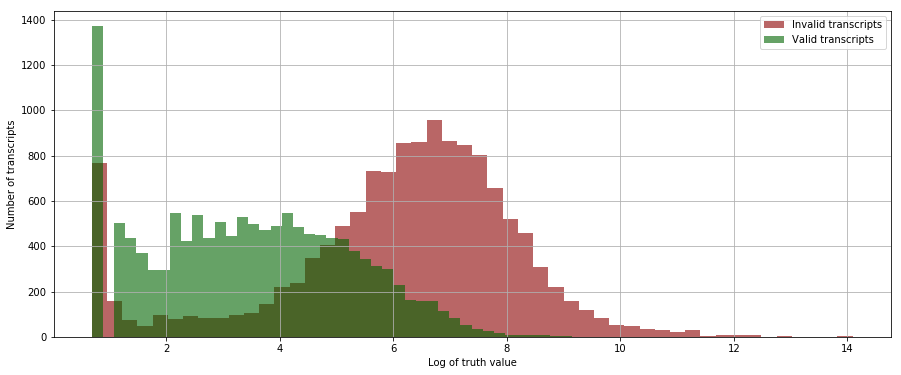

In [13]:
plt.rcParams['figure.figsize'] = (15, 6) 

data[data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkred')
data[~data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkgreen')
plt.xlabel('Log of truth value')
plt.ylabel('Number of transcripts')
plt.legend(['Invalid transcripts', 'Valid transcripts'])

#### Valid and Invalid transcripts show little variance w.r.t 'Length' and 'Effective Length' features

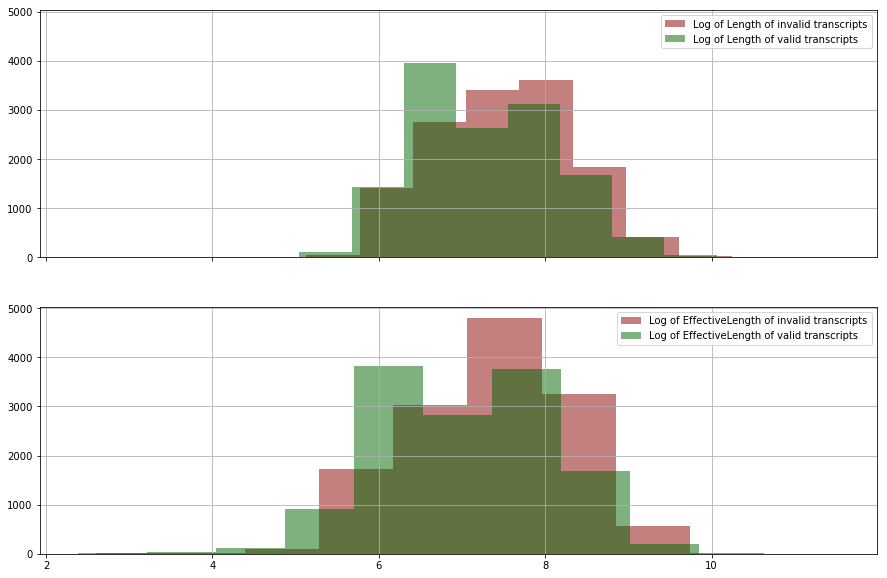

In [14]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])

#### Valid and Invalid transcripts exhibit variance w.r.t 'TPM' and 'NumReads'.

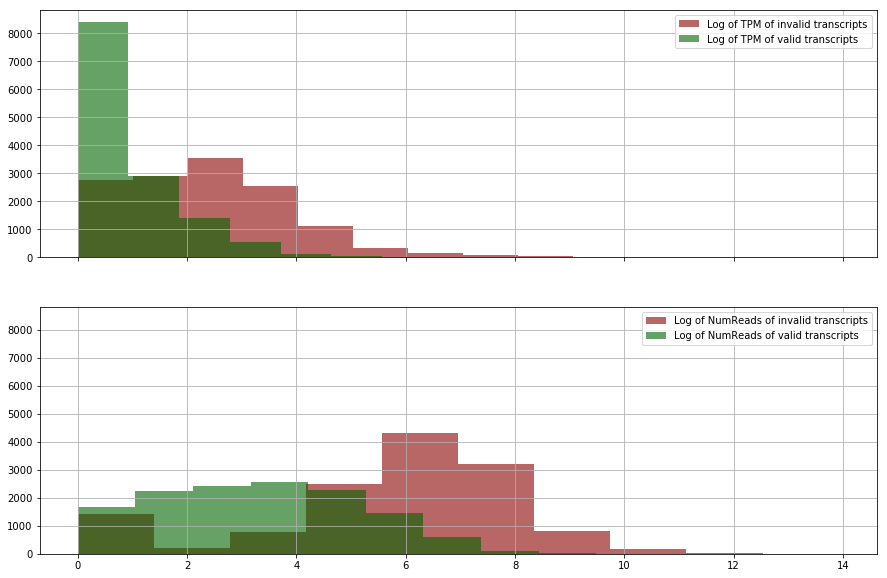

In [15]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['TPM', 'NumReads']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])

#### Bootstrapping generally underestimates the count, but when it overestimates, there are some transcripts that are very highly overestimated.

The graph below shows that most estimations are close to **0**, i.e. the estimates have some error. However, there are some outliers so far away from origin showing that they're so highly overestimated.

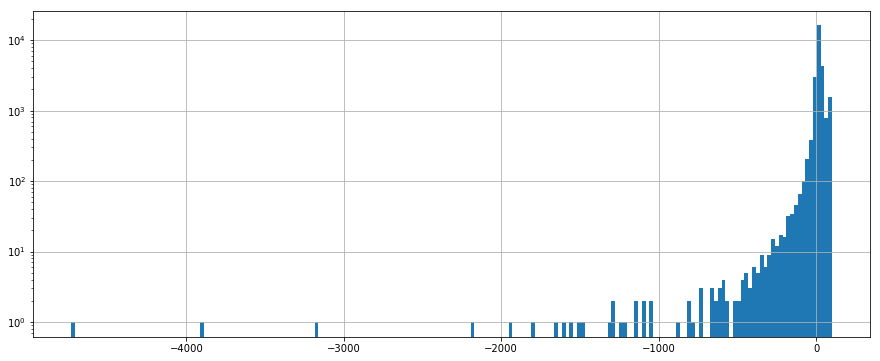

In [16]:
plt.rcParams['figure.figsize'] = (15, 6) 
fig.set_size_inches(15,10)

data['mape'].hist(log=True, bins=200)

In [17]:
(data['mape']>0).value_counts()

True     23920
False     2969
Name: mape, dtype: int64

#### Mean Absolute percentage Error as it relates to valid/invalid (Not normalized)

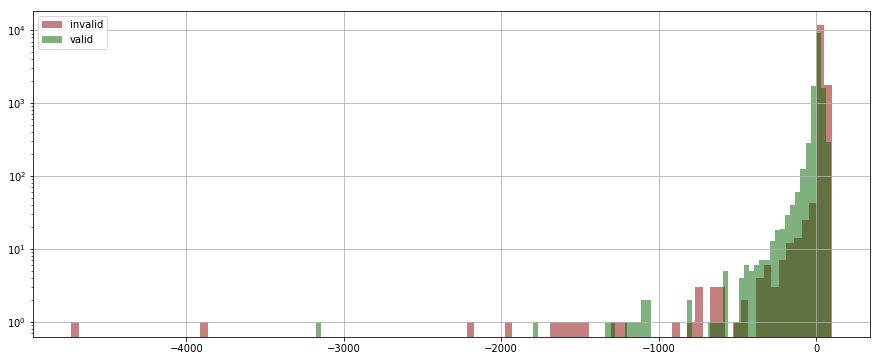

In [18]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkred')
data[~data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkgreen')
plt.legend(['invalid', 'valid'])

#### Normalized mean error with respect to valid invalid transcripts
After normalization, there's a clear distinction between the valid and invalid transcripts. Valid ones are almost very close to zero but invalid are scattered in a big range.

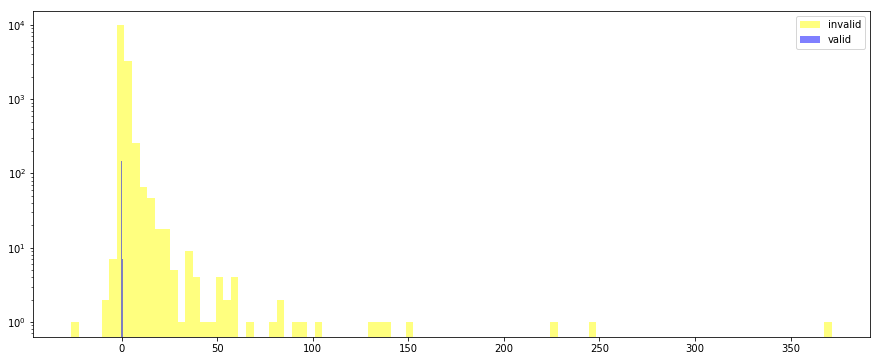

In [19]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='yellow')
data[~data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='blue')
plt.legend(['invalid', 'valid'])
plt.grid(False)

#### Most transcripts that have a small error are valid
The code below shows the count of **valid** and **invalid** transcripts for **Mean Absolute percentage error** of **<5**

In [20]:
data[np.abs(data['mape']) < 5]['invalid'].value_counts()

False    2714
True       57
Name: invalid, dtype: int64

### Relationship between mean error normalized and (Length, Effective Length, TPM and NumReads)

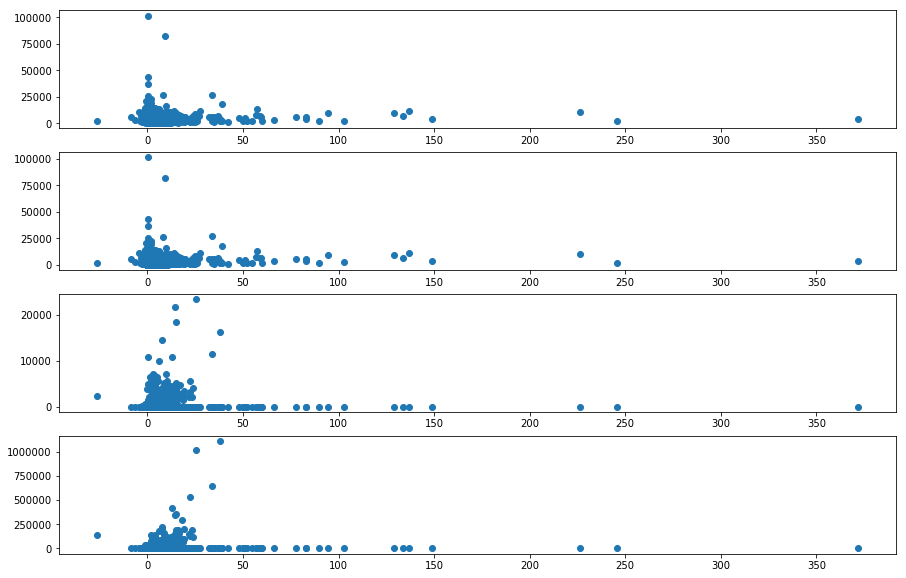

In [21]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

for i, prop in enumerate(properties):
    axs[i].scatter(data['mae_n'], data[prop])

Zooming into above graphs.

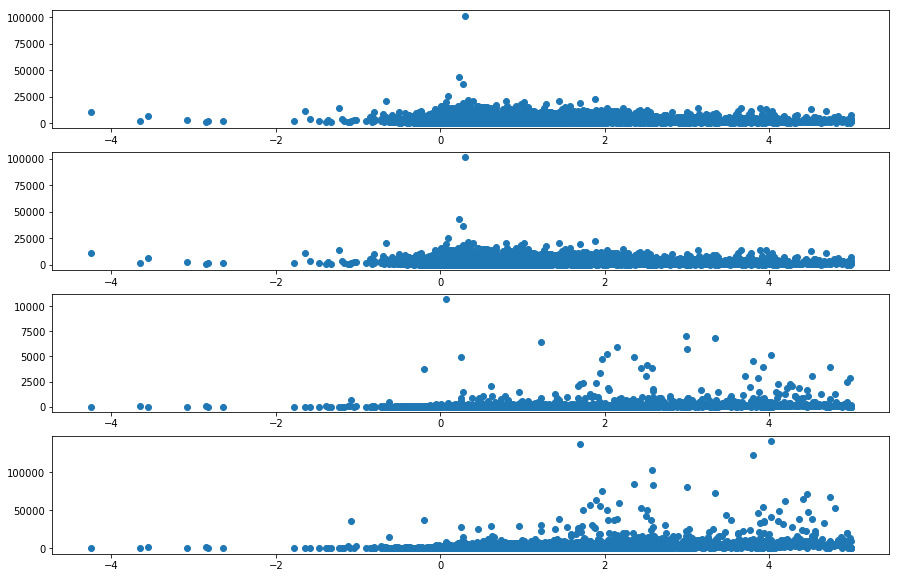

In [23]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

filtered = data[np.abs(data['mae_n']) < 5]

for i, prop in enumerate(properties):
    axs[i].scatter(filtered['mae_n'], filtered[prop])


#### Looking into the error in continuous domain
We had **valid** and **invalid** transcripts in the discrete domain calculated based on the confidence intervals from the bootstrap samples. Because the results weren't that convincing, the idea of **continuous error** measure seems like a valid idea. 
The plot below shows the evaluation of the **mean absolute percentage error** of both **valid and invalid** transcripts.

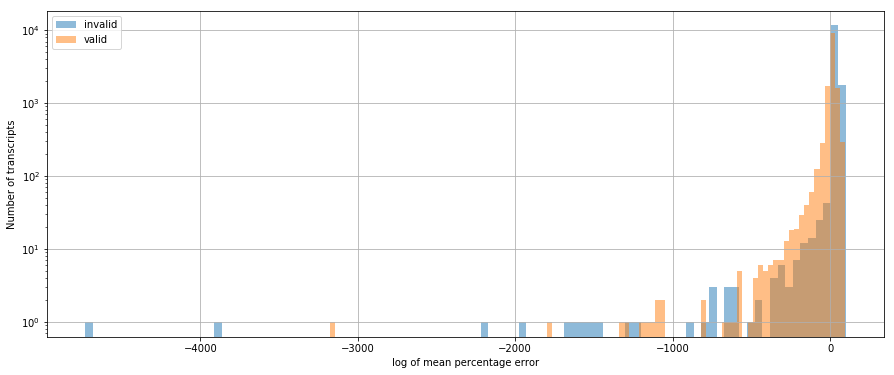

In [24]:
data[data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100)
data[~data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100)
plt.legend(['invalid','valid'])
plt.xlabel('log of mean percentage error')
plt.ylabel('Number of transcripts')

Plot for the distribution of **standard deviation** for valid and invalid transcripts.

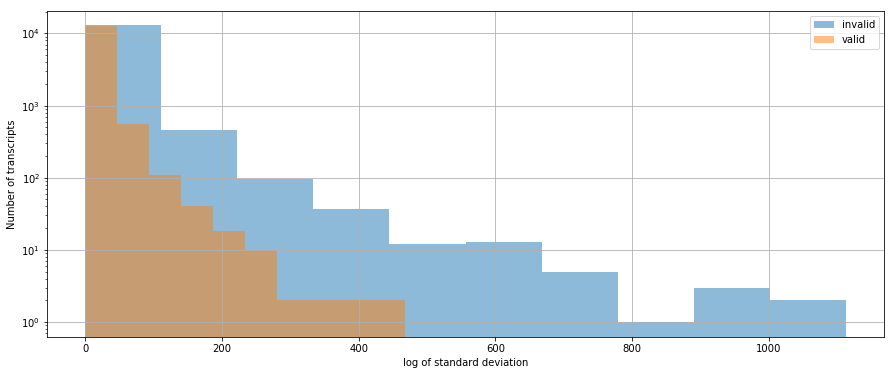

In [26]:
data[data['invalid']]['std'].hist(log=True, alpha=0.5)
data[~data['invalid']]['std'].hist(log=True, alpha=0.5)
plt.legend(['invalid', 'valid'])
plt.xlabel('log of standard deviation')
plt.ylabel('Number of transcripts')

As observed from the data, **Num Reads** acts as an important predictor for **valid** and **invalid** transcripts. It'll be interesting to know the **correlation** between the **Mean percentage error** and **Num Reads**.

In [27]:
data['mape'].min()

-4731.8401358695382

In [28]:
from scipy.stats import pearsonr

In [29]:
pearsonr(abs(data['mape']), data['NumReads'])

(-0.016308857737198885, 0.0074872451768554678)

The correlation value of **-0.0025** shows that Num Reads and Mean Absolute percentage error are very slightly correlated if at all.
The plot below shows the **Mean absolute percentage error** for **Num Reads**.

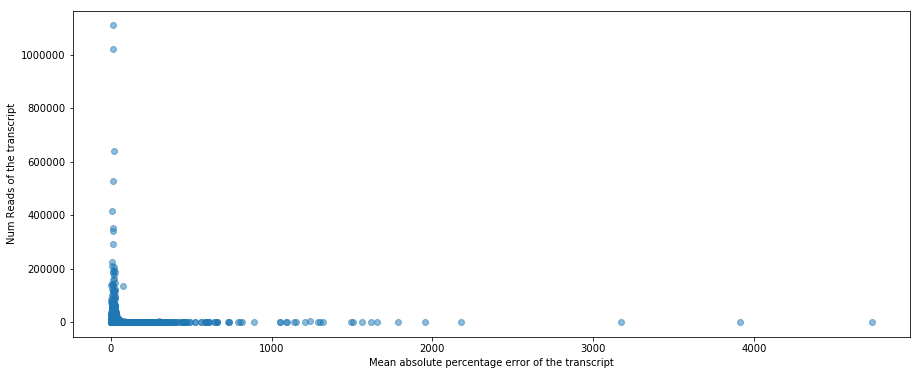

In [30]:
properties = ['TPM', 'NumReads']
plt.scatter(data['mape'].apply(lambda x: np.abs(x)), data['NumReads'], alpha=0.5)
plt.xlabel('Mean absolute percentage error of the transcript')
plt.ylabel('Num Reads of the transcript')

Most number of Transcripts have a very small mean absolute percentage error as shows in above figure.

#### Relation between the truth values and the mean
The **mean** has the same distribution as the **truth values** but is slightly shifted to the left.

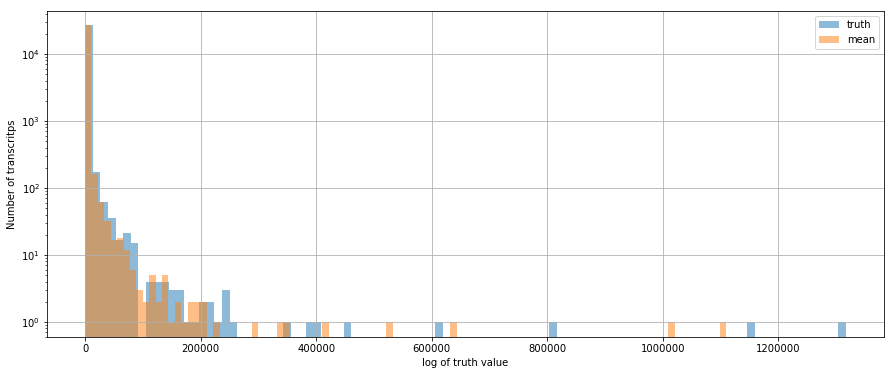

In [31]:
data['truth'].hist(log=True, alpha=0.5, bins=100)
data['mean'].hist(log=True, alpha=0.5, bins=100)
plt.legend(['truth','mean'])
plt.xlabel('log of truth value')
plt.ylabel('Number of transcritps')

### 4. Valid and invalid transcripts are often found together in equivalent classes

We tried to find out how the **invalid** transcripts are distributed in the **equivalence classes**. More importantly, do all the invalid transcripts are grouped in same equivalence classes?
The plot below shows that the **invalid** equivalence classes occur even with valid transcripts in equivalence classes.

In [40]:
percentages_invalid = []

for eclass in classes:
    invalid_count = 0
    for transcript_idx in eclass[1:-1]:
        if transcripts[int(transcript_idx)] in invalid_ts:
            invalid_count += 1
    percentage_invalid = (invalid_count*100)/float(eclass[0])
    percentages_invalid.append(percentage_invalid)

KeyError: 61539

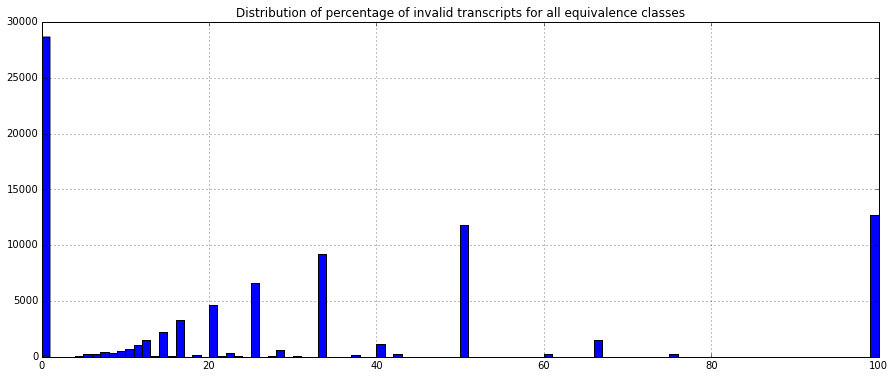

In [123]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.grid()
pd.Series(percentages_invalid).hist(bins=100)
plt.title('Distribution of percentage of invalid transcripts for all equivalence classes')

### 5. Number of classes valid and invalid transcripts belong to 

#### 5.1. Approach 1
Creating a new property for each transcript: the number of equivalence classes it belongs to.

In [33]:
all_ts = [int(transcript_idx) for eclass in classes for transcript_idx in eclass[1:-1]]
ts_eclass_counts = pd.DataFrame(pd.Series(all_ts).value_counts(), columns=['eclass_cnt'])

In [34]:
transcripts = pd.DataFrame(transcripts, columns=['transcript'])
merged = pd.merge(ts_eclass_counts, transcripts, left_index=True, right_index=True)

In [35]:
merged.index = merged['transcript']; del merged['transcript']

In [36]:
data['eclass_cnt'] = merged['eclass_cnt']

In [37]:
data['eclass_cnt'] = data['eclass_cnt'].fillna(0)

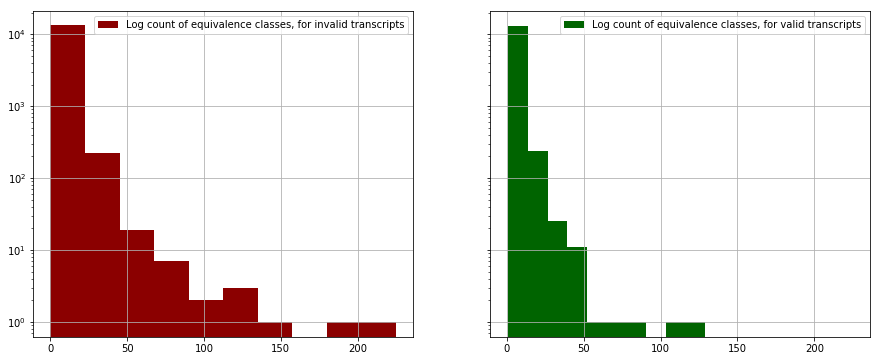

In [38]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
# fig.set_size_inches(15,15)

prop = 'eclass_cnt'

ax1 = data[data['invalid']][prop].hist(ax=axs[0], log=True, color='darkred')#.apply(lambda x: log(x+1))
ax1.legend(['Log count of equivalence classes, for invalid transcripts'])

ax = data[~data['invalid']][prop].hist(ax=axs[1], log=True, color='darkgreen')
ax.legend(['Log count of equivalence classes, for valid transcripts'])

#### 5.2. Approach 2

In [81]:
merged.head()

,eclass_cnt
transcript,
ENST00000369202,225
ENST00000369339,189
ENST00000605176,188
ENST00000342960,187
ENST00000369365,168


In [79]:
eq_df.groupby('transcript').apply(lambda x: )

SyntaxError: invalid syntax (<ipython-input-79-80c425a55669>, line 1)

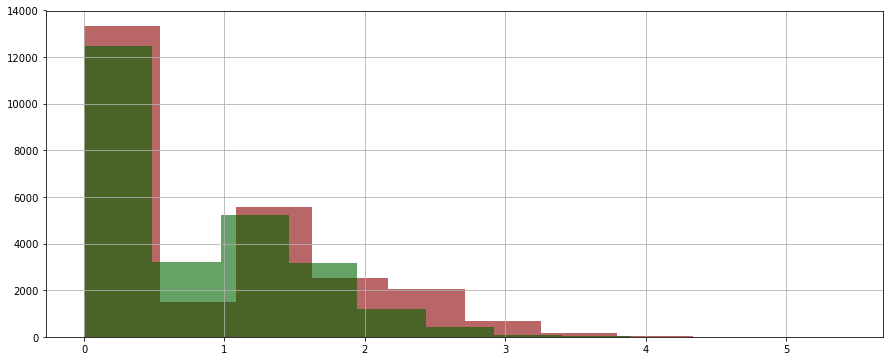

In [45]:
merged.groupby('transcript').apply(lambda x: x[x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkred')
merged.groupby('transcript').apply(lambda x: x[~x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkgreen')

### Sum of numreads weighted by size of equivalent classes it belongs to
Digging deeper into equivalence classes, we tried to give each transcript a weight based on the average number of reads that come from it. To calculate the weight, we use the below formula.

Suppose transcript **$T_{1}$** appears in equivalence classes **$E_{1}$** and **$E_{2}$**. Class **$E_{1}$** has number of reads **$R_{1}$** and class **$E_{2}$** has number of reads **$R_{2}$** with number of members **$N_{1}$** and **$N_{2}$** respectively. So:

Weight of **$T_{1}$** = **($R_{1}$/$N_{1}$ + $R_{2}$/$N_{2}$)**

In [46]:
weightedreads = merged.groupby('transcript').apply(lambda x: sum(x['numreads'])).reset_index()
# plt.scatter(weightedreads, ['NumReads'])


In [47]:
weightedreads.columns = ['transcript', 'wreads']

In [48]:
wr_merged = pd.merge(data, weightedreads, left_index=True, right_on=['transcript'])

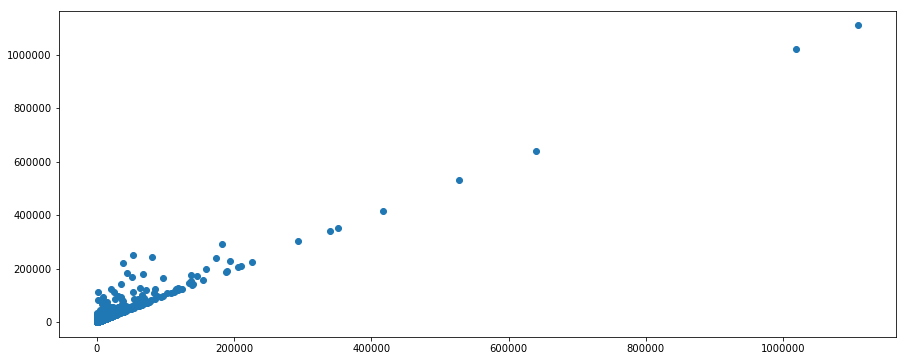

In [49]:
plt.scatter(wr_merged['NumReads'], wr_merged['wreads'])

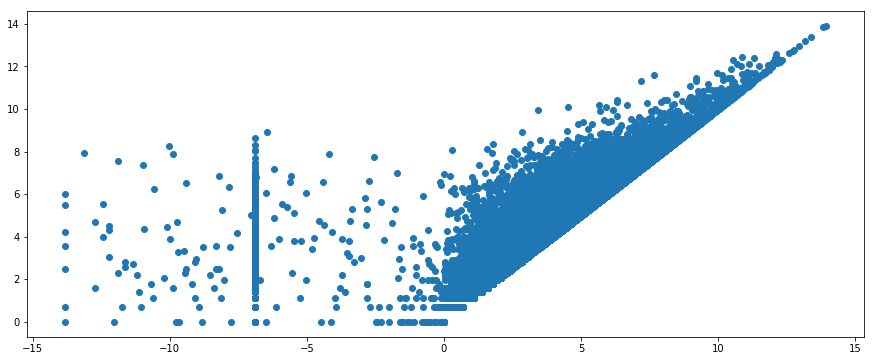

In [50]:
plt.scatter(wr_merged['NumReads'].apply(lambda x: log(x) if x!=0 else log(0.001)), wr_merged['wreads'].apply(lambda x: log(x) if x!=0 else log(0.001)))

In [51]:
invalid = merged[merged['invalid']]
valid = merged[~merged['invalid']]

In [55]:
wr_merged.head()

,0,1,2,3,4,5,6,7,8,9,...,invalid,mape,mae_n,Length,EffectiveLength,TPM,NumReads,eclass_cnt,transcript,wreads
9693,19.272902,21.122520,21.754805,22.437591,22.674037,23.822094,24.348252,24.387028,25.785329,26.017682,...,False,16.997120,0.145752,1420,1220.991,1.180968,46.855146,3.0,ENST00000382369,125
6510,13.465284,15.456381,16.625515,17.269747,19.044385,19.792498,20.374741,20.605138,20.910507,21.264112,...,False,22.998302,0.203210,1575,1375.991,0.912080,40.780781,4.0,ENST00000360321,129
11047,40.970483,45.874537,46.154529,46.272003,47.886339,48.150061,48.583841,50.326164,52.084900,53.358409,...,False,22.850545,0.330594,1022,822.991,2.705958,72.364073,3.0,ENST00000400269,109
9692,1921.000000,1928.000000,1932.000000,1940.000000,1940.000000,1943.000000,1943.000000,1950.000000,1953.000000,1961.000000,...,True,23.266114,2.550620,3229,3029.991,20.638372,2032.000000,1.0,ENST00000382352,2032
5401,1886.000000,1896.000000,1903.000000,1905.000000,1905.000000,1913.000000,1916.000000,1920.000000,1920.000000,1920.000000,...,True,28.786912,3.464313,4627,4427.991,13.886148,1998.000000,2.0,ENST00000342665,1998


In [52]:
valid.groupby('transcript').apply(lambda x: sum(x['overlap'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkgreen')
invalid.groupby('transcript').apply(lambda x: sum(x['overlap'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkred')

KeyError: 'overlap'

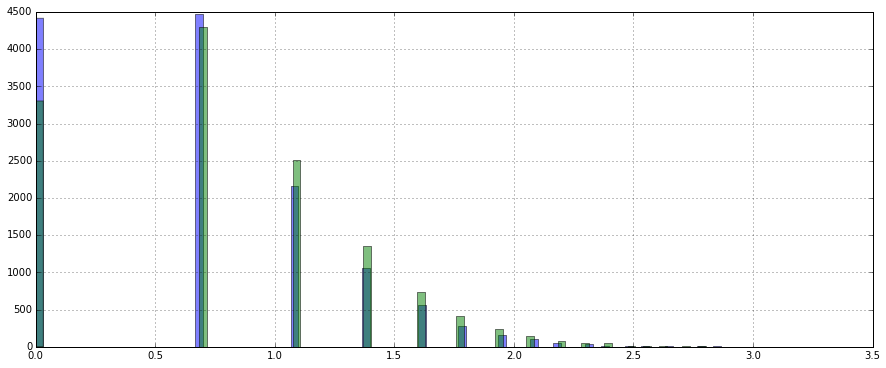

In [158]:
valid.groupby('transcript').apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log).hist(alpha=0.5, bins=100)
invalid.groupby('transcript').apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log).hist(alpha=0.5, bins=100)

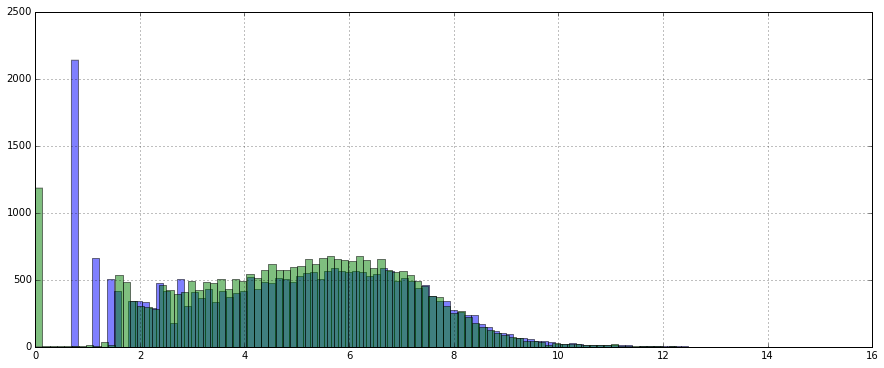

In [172]:
data['truth'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)
data['max'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)

In [ ]:
eq_df_uniques = eq_df[['eclass_id', 'eclass_len', 'overlap']].drop_duplicates()

from math import log 

plt.rcParams['figure.figsize'] = (15, 6)
plt.scatter(eq_df_uniques['eclass_len'], eq_df_uniques['overlap'].apply(lambda x: log(x+1)), alpha=1, s=30)
plt.grid()
plt.xlabel('Length of equivalent classes')
plt.ylabel('Overlap of equivalent classes')
plt.title("Relationship between length and overlap of equivalent classes")
plt.show()

In [ ]:
eq_df[eq_df['eclass_len'] == 1]['overlap'].apply(log).hist()

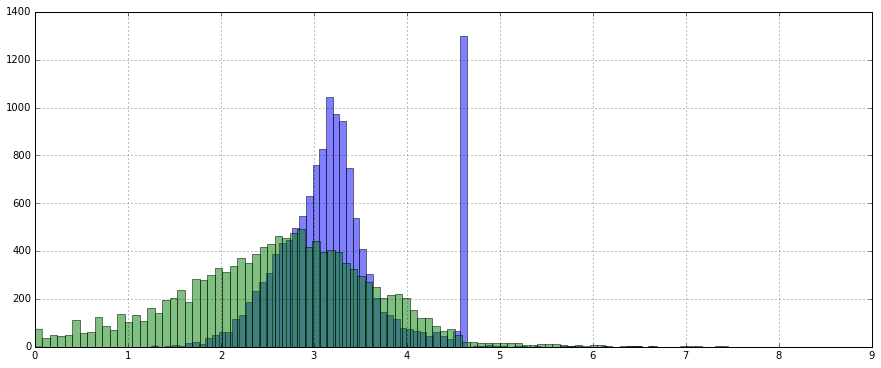

In [157]:
data[data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)
data[~data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)

In [55]:
data[['invalid', 'truth', 'quality', 'quality2']]

,erroneous,truth,quality,quality2
ENST00000608495,True,1,20000.000000,100.000000
ENST00000382369,False,55,4732.443537,16.997120
ENST00000360321,False,54,5150.160300,22.998302
ENST00000400269,False,92,4639.511821,22.850545
ENST00000382352,True,2653,4653.222767,23.266114
ENST00000342665,True,2804,5757.382311,28.786912
ENST00000609179,True,261,5947.126437,29.735632
ENST00000217233,True,382,5935.956118,29.679781
ENST00000449710,True,350,6630.657128,33.153286
ENST00000422053,True,259,4691.683835,23.435034


In [58]:
"Minimum/Maximum error: %s/%s" % (data['mape'].min(), data['mape'].max())

'Minimum/Maximum error: -4731.84013587/100.0'

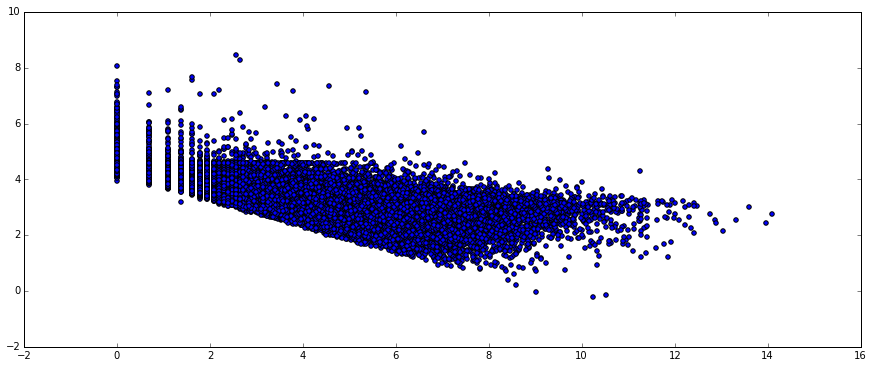

In [67]:
plt.scatter(data['truth'].apply(log), data['mape'].apply(log))

In [60]:
plt.scatter?

In [65]:
eq_classes_count = eq_df.groupby('transcript').apply(lambda x: x['eclass_id'].unique().shape[0])

In [66]:
eq_classes_count

transcript
ENST00000000233     2
ENST00000000412     3
ENST00000000442     8
ENST00000001008     2
ENST00000002125     9
ENST00000002165     3
ENST00000002501     3
ENST00000002596     2
ENST00000003084     1
ENST00000003100     2
ENST00000003302    14
ENST00000003583     2
ENST00000003912     1
ENST00000004103     5
ENST00000004980     9
ENST00000004982     2
ENST00000005082    12
ENST00000005178     1
ENST00000005257     2
ENST00000005259     1
ENST00000005260     2
ENST00000005284     1
ENST00000005286     9
ENST00000005340     4
ENST00000005374     5
ENST00000005386     4
ENST00000005558     1
ENST00000006053     4
ENST00000006251     7
ENST00000006275     5
                   ..
ENST00000610127     2
ENST00000610128     1
ENST00000610130     1
ENST00000610139     2
ENST00000610140     6
ENST00000610144     8
ENST00000610153     5
ENST00000610154     3
ENST00000610158     1
ENST00000610162     1
ENST00000610171     1
ENST00000610177     1
ENST00000610179     3
ENST00000610180    41

In [20]:
data.shape, merged.shape, eq_df.shape, 324478-121649, 121649-26889

((26889, 214), (121649, 10), (324478, 4), 202829, 94760)

In [24]:
merged.head()

,eclass_id,eclass_size,transcript,numreads,invalid,min,max,std,truth,mape
0,0,1,ENST00000375898,385,True,329.000000,434.000000,19.682014,462,16.237013
2,1,4,ENST00000563559,47,True,1271.113536,1481.382832,37.884988,1473,6.225029
89810,24518,5,ENST00000563559,25,True,1271.113536,1481.382832,37.884988,1473,6.225029
101516,27786,5,ENST00000563559,657,True,1271.113536,1481.382832,37.884988,1473,6.225029
127144,34956,3,ENST00000563559,25,True,1271.113536,1481.382832,37.884988,1473,6.225029


In [23]:
quant.head()

,Length,EffectiveLength,TPM,NumReads
Name,,,,
ENST00000382410,587,388.005,0,0
ENST00000382398,655,456.001,0,0
ENST00000382388,514,315.007,0,0
ENST00000334391,373,174.012,0,0
ENST00000246105,698,499.000,0,0


In [25]:
merged2 = pd.merge(merged, quant, left_on='transcript', right_index=True)

In [28]:
merged2.head()

,eclass_id,eclass_size,transcript,numreads,invalid,min,max,std,truth,mape,Length,EffectiveLength,TPM,NumReads
0,0,1,ENST00000375898,385,True,329.000000,434.000000,19.682014,462,16.237013,5338,5138.991,2.305557,385.000000
2,1,4,ENST00000563559,47,True,1271.113536,1481.382832,37.884988,1473,6.225029,2128,1928.991,22.055163,1382.443488
89810,24518,5,ENST00000563559,25,True,1271.113536,1481.382832,37.884988,1473,6.225029,2128,1928.991,22.055163,1382.443488
101516,27786,5,ENST00000563559,657,True,1271.113536,1481.382832,37.884988,1473,6.225029,2128,1928.991,22.055163,1382.443488
127144,34956,3,ENST00000563559,25,True,1271.113536,1481.382832,37.884988,1473,6.225029,2128,1928.991,22.055163,1382.443488


## Classification

In [183]:
grobj = merged2.groupby('transcript')

X_y = pd.DataFrame(index=set(merged2['transcript']))

X_y['num_classes'] = grobj.apply(lambda x: x['eclass_id'].unique().shape[0]).apply(log)

X_y['feature2'] = grobj.apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log)
X_y['feature3'] = grobj.apply(lambda x: sum(x['eclass_size'])).apply(log)
X_y['feature4'] = grobj.apply(lambda x: sum(x['numreads'])/len(x)).apply(log)
X_y['weighted_reads'] = grobj.apply(lambda x: sum(x['numreads']/x['eclass_size'])).apply(log)
X_y['nu_other_trs'] = grobj.apply(lambda x: sum(x['eclass_size'])).apply(log)

X_y['avg_class_length'] = grobj.apply(lambda x: sum(x['Length'])/len(x)).apply(log)
X_y['avg_class_elength'] = grobj.apply(lambda x: sum(x['EffectiveLength'])/len(x)).apply(log)
X_y['avg_class_tpm'] = grobj.apply(lambda x: sum(x['TPM'])/len(x)).apply(lambda x: log(x+1))
X_y['avg_class_numreads'] = grobj.apply(lambda x: sum(x['NumReads'])/len(x)).apply(lambda x: log(x+1))

X_y['min'] = data_mins
X_y['maxs'] = data_maxs
X_y['mean'] = data_means
X_y['std'] = data_std

X_y['truth'] = data['truth']
X_y['invalid'] = data['invalid']
X_y['mape'] = data['mape']
X_y['mae_n'] = data['mae_n']

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score 
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR

X = X_y[X_y.columns[:-4]]
y_mape = X_y['mape']
y_mae_n = X_y['mae_n']
y_truth = X_y['truth']
y_invalid = X_y['invalid']

X_s = pd.DataFrame(scale(X), columns=X.columns)

X_s, y_mae_n = shuffle(X_s, y_mae_n)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_mae_n, test_size=0.3)

# clf = LinearRegression()
clf = SVR()
# clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
mean_squared_error(y_test, pred), r2_score(y_test, pred)
# print classification_report(y_test, pred)

(8.0440003308664529, 0.087502775326086746)

## akjdfb

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score 
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from scipy import stats
# X = X_y[X_y.columns[:-4]]
# y_mape = X_y['mape']
# y_mae_n = X_y['mae_n']
# y_truth = X_y['truth']
# y_invalid = X_y['invalid']

# X_s = pd.DataFrame(scale(X), columns=X.columns)

# X_s, y_mape = shuffle(X_s, y_invalid)

X = data[['NumReads']]
X['NumReads'] = X['NumReads'].apply(lambda x: log(x+1))
X_train, X_test, y_train, y_test = train_test_split(X, data['invalid'], test_size=0.3)

# clf = LinearRegression()
clf = GausqsianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# mean_squared_error(y_test, pred), r2_score(y_test, pred)

print classification_report(y_test, pred)

             precision    recall  f1-score   support

      False       0.76      0.78      0.77      3992
       True       0.78      0.76      0.77      4075

avg / total       0.77      0.77      0.77      8067

